## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

#import tensorflow as tf
import keras

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
39401,00010319_008.png,No Finding,8,10319,59,M,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010319_008.png
44526,00011460_000.png,No Finding,0,11460,16,M,PA,2500,2048,0.168,0.168,NaN,/data/images_005/images/00011460_000.png
49630,00012603_012.png,No Finding,12,12603,65,M,PA,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012603_012.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

from itertools import chain

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df['Number of Diseases'] = all_xray_df['Finding Labels'].map(lambda finding: 0 if finding == 'No Finding' else finding.count('|') + 1)

In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda b: 'True' if b else 'False')
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax',
       'Number of Diseases', 'pneumonia_class'],
      dtype='object')

In [6]:
def find_image(image_file):
    for suffix in range(1, 13):
        zeros = '00' if suffix < 10 else '0'
        path = f'/data/images_{zeros}{suffix}/images'
        image_path = f'{path}/{image_file}'
        if os.path.exists(image_path): return image_path
    return None

all_xray_df['Image File'] = all_xray_df['Image Index'].map(find_image)

In [7]:
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of Diseases,pneumonia_class,Image File
65040,00016053_000.png,Consolidation,0,16053,23,F,PA,2454,2991,0.143,...,0,0,0,0,0,0,0,1,False,/data/images_008/images/00016053_000.png
76454,00018766_013.png,No Finding,13,18766,66,M,AP,2500,2048,0.168,...,0,0,1,0,0,0,0,0,False,/data/images_009/images/00018766_013.png
8017,00002104_001.png,No Finding,1,2104,28,M,AP,3056,2544,0.139,...,0,0,1,0,0,0,0,0,False,/data/images_002/images/00002104_001.png
100048,00026513_005.png,No Finding,5,26513,55,M,AP,3056,2544,0.139,...,0,0,1,0,0,0,0,0,False,/data/images_011/images/00026513_005.png
81592,00020060_010.png,No Finding,10,20060,55,F,PA,2992,2991,0.143,...,0,0,1,0,0,0,0,0,False,/data/images_009/images/00020060_010.png


## Create your training and testing data:

In [8]:
from sklearn.model_selection import train_test_split

FACTOR = 10 #5

def create_splits(train_percent = 0.80):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    pneumonia_df = all_xray_df[all_xray_df.Pneumonia == 1]
    non_pneumonia_df = all_xray_df[all_xray_df.Pneumonia == 0]
    n = all_xray_df.shape[0]
    print('Pneumonia cases: {} ({:.2f}%)'.format(pneumonia_df.shape[0], 100. * pneumonia_df.shape[0] / n))
    print('Non-pneumonia cases: {} ({:.2f}%)'.format(non_pneumonia_df.shape[0], 100. * non_pneumonia_df.shape[0] / n))
    train_indexes, val_indexes = train_test_split(np.arange(pneumonia_df.shape[0]), train_size = train_percent, random_state = 42)
    train_data = pneumonia_df.iloc[train_indexes]
    val_data = pneumonia_df.iloc[val_indexes]
    n_train_data = train_data.shape[0]
    non_pneumonia_indexes = np.random.choice(non_pneumonia_df.shape[0], pneumonia_df.shape[0] * FACTOR, replace = False)
    train_data = train_data.append(non_pneumonia_df.iloc[non_pneumonia_indexes[:n_train_data]])
    val_data = val_data.append(non_pneumonia_df.iloc[non_pneumonia_indexes[n_train_data * FACTOR:]])
    train_data = train_data.sample(frac = 1).reset_index(drop = True)
    val_data = val_data.sample(frac = 1).reset_index(drop = True)
    return train_data, val_data

train_data, val_data = create_splits()

print('Due to the very imbalance nature of the pneumonia cases versus non-pneumonia cases (1.28:98.72),')
print(f'I decided to balance the validation dataset with a proportion of (1:{FACTOR}).\n')
print('{} (pneumonia train) + {} (non_pneumonia train) = {} (all train)'.format(
    train_data[train_data.Pneumonia == 1].shape[0], 
    train_data[train_data.Pneumonia == 0].shape[0], 
    train_data.shape[0]))
print('{} (pneumonia val) + {} (non_pneumonia val) = {} (all val)'.format(
    val_data[val_data.Pneumonia == 1].shape[0], 
    val_data[val_data.Pneumonia == 0].shape[0], 
    val_data.shape[0]))
train_data.sample(10)

Pneumonia cases: 1431 (1.28%)
Non-pneumonia cases: 110689 (98.72%)
Due to the very imbalance nature of the pneumonia cases versus non-pneumonia cases (1.28:98.72),
I decided to balance the validation dataset with a proportion of (1:10).

1144 (pneumonia train) + 1144 (non_pneumonia train) = 2288 (all train)
287 (pneumonia val) + 2870 (non_pneumonia val) = 3157 (all val)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of Diseases,pneumonia_class,Image File
1506,00016728_005.png,Atelectasis|Infiltration|Pneumonia,5,16728,53,F,PA,2944,2937,0.143000,...,1,0,0,0,0,1,0,3,True,/data/images_008/images/00016728_005.png
2267,00008482_000.png,No Finding,0,8482,34,M,PA,2500,2048,0.168000,...,0,0,1,0,0,0,0,0,False,/data/images_004/images/00008482_000.png
1093,00027706_020.png,Edema|Infiltration|Pneumonia,20,27706,36,M,AP,3056,2544,0.139000,...,1,0,0,0,0,1,0,3,True,/data/images_011/images/00027706_020.png
1992,00015806_003.png,Pneumonia,3,15806,37,M,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,1,True,/data/images_007/images/00015806_003.png
2250,00001664_000.png,Pleural_Thickening,0,1664,53,F,PA,2048,2500,0.168000,...,0,0,0,0,1,0,0,1,False,/data/images_002/images/00001664_000.png
1516,00013078_001.png,No Finding,1,13078,42,M,PA,2500,2048,0.168000,...,0,0,1,0,0,0,0,0,False,/data/images_006/images/00013078_001.png
1188,00016119_001.png,Infiltration|Pneumonia,1,16119,60,M,PA,2992,2991,0.143000,...,1,0,0,0,0,1,0,2,True,/data/images_008/images/00016119_001.png
548,00014956_010.png,Atelectasis|Mass|Nodule|Pneumonia,10,14956,42,M,AP,2500,2048,0.168000,...,0,1,0,1,0,1,0,4,True,/data/images_007/images/00014956_010.png
1125,00014197_031.png,Atelectasis|Pneumonia,31,14197,57,M,PA,2890,2991,0.143000,...,0,0,0,0,0,1,0,2,True,/data/images_007/images/00014197_031.png
678,00004625_003.png,No Finding,3,4625,53,F,PA,2021,2021,0.194311,...,0,0,1,0,0,0,0,0,False,/data/images_003/images/00004625_003.png


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 64 #128
rescale = 1. / 255

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    idg = ImageDataGenerator(rescale = rescale, horizontal_flip = True, vertical_flip = False,
                            height_shift_range = 0.1, width_shift_range = 0.1, rotation_range = 20,
                            shear_range = 0.1, zoom_range = 0.1)
    return idg


def make_train_gen():
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    idg = my_image_augmentation()
    train_gen = idg.flow_from_dataframe(dataframe = train_data, directory = None, 
                                        x_col = 'Image File', y_col = 'pneumonia_class', class_mode = 'binary', 
                                        target_size = IMG_SIZE, batch_size = BATCH_SIZE)
    return train_gen


def make_val_gen():
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_idg = ImageDataGenerator(rescale = rescale)
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data, directory = None, 
                                      x_col = 'Image File', y_col = 'pneumonia_class', class_mode = 'binary', 
                                      target_size = IMG_SIZE, batch_size = BATCH_SIZE)
    return val_gen

In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_gen = make_train_gen()
val_gen = make_val_gen()
valX, valY = val_gen.next()

Found 2288 validated image filenames belonging to 2 classes.
Found 3157 validated image filenames belonging to 2 classes.


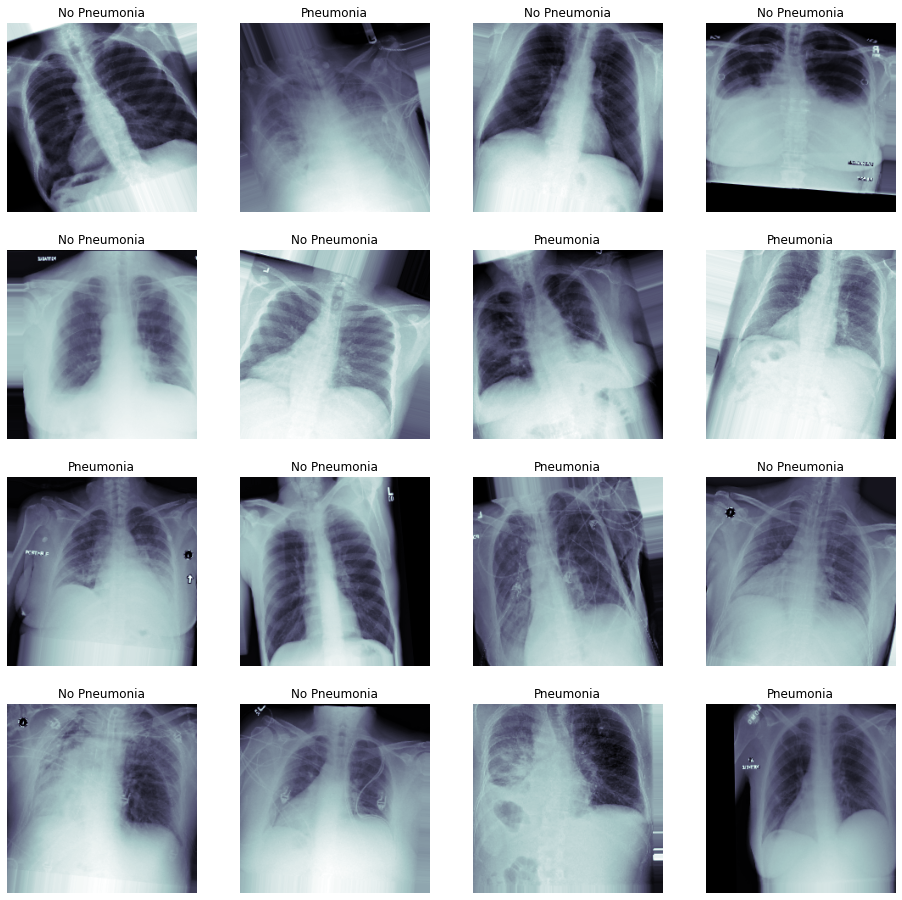

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
from keras.applications.vgg16 import VGG16
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    vgg_model = VGG16(include_top=True, weights='imagenet')
    vgg_model.summary()
    return vgg_model

vgg_model = load_pretrained_model()

553467904/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [13]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    new_model = Sequential()
    for layer in vgg_model.layers[:-1]:
        layer.trainable = False
        new_model.add(layer)
    new_model.add(Dense(1024 * 2, activation='relu'))
    new_model.add(Dropout(0.25))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.25))
    new_model.add(Dense(1, activation='sigmoid'))
    new_model.summary()
    
    return new_model
    
model = build_my_model(vgg_model)    
    
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [14]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

weight_path = 'best_weights.hdf5'
#monitor_var = 'val_loss' 
monitor_var = 'val_binary_accuracy'

checkpoint = keras.callbacks.ModelCheckpoint(
    weight_path, monitor = monitor_var, verbose = 1, save_best_only = True,
    save_weights_only = True, mode = 'auto')

early = keras.callbacks.EarlyStopping(
    monitor = monitor_var, min_delta = 0, patience = 10, verbose = 1, mode = 'auto',
    baseline = None, restore_best_weights = True)

callbacks_list = [checkpoint, early]

### Start training! 

In [15]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

optimizer = keras.optimizers.Adam(lr = 1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
model.compile(optimizer = optimizer, loss = loss, metrics=metrics)

history = model.fit_generator(train_gen, validation_data = (valX, valY), epochs = 200, callbacks = callbacks_list)

Epoch 1/200
36/36 [==============================] - 69s 2s/step - loss: 0.7543 - binary_accuracy: 0.5096 - val_loss: 0.8375 - val_binary_accuracy: 0.0469

Epoch 00001: val_binary_accuracy improved from -inf to 0.04688, saving model to best_weights.hdf5
Epoch 2/200
36/36 [==============================] - 61s 2s/step - loss: 0.7197 - binary_accuracy: 0.5140 - val_loss: 0.6608 - val_binary_accuracy: 0.6250

Epoch 00002: val_binary_accuracy improved from 0.04688 to 0.62500, saving model to best_weights.hdf5
Epoch 3/200
36/36 [==============================] - 59s 2s/step - loss: 0.7052 - binary_accuracy: 0.5328 - val_loss: 0.5457 - val_binary_accuracy: 0.9375

Epoch 00003: val_binary_accuracy improved from 0.62500 to 0.93750, saving model to best_weights.hdf5
Epoch 4/200
36/36 [==============================] - 60s 2s/step - loss: 0.7073 - binary_accuracy: 0.5328 - val_loss: 0.5930 - val_binary_accuracy: 0.8125

Epoch 00004: val_binary_accuracy did not improve from 0.93750
Epoch 5/200
36

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [16]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = BATCH_SIZE, verbose = True)

64/64 [==============================] - 1s 10ms/step


In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
## what other performance statistics do you want to include here besides AUC? 
    
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def calc_f1(prec, recall):
    return 2 * (prec * recall) / (prec + recall)
    
#Also consider plotting the history of your model training:

def plot_loss_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#     plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
#     plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Learning Curve (Loss versus Epochs)")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    
def plot_acc_history(history):
    N = len(history.history["binary_accuracy"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Learning Curve (Accuracy versus Epochs)")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper right")


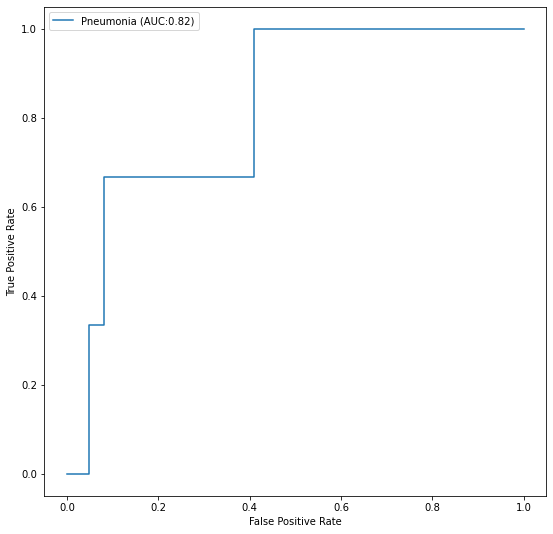

In [18]:
plot_auc(valY, pred_Y)

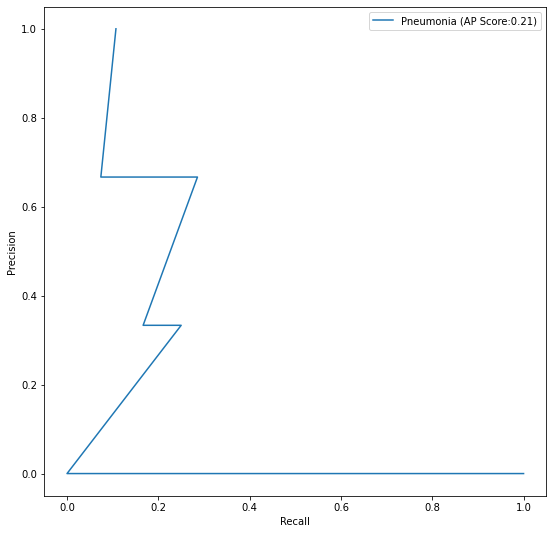

In [19]:
plot_pr(valY, pred_Y)

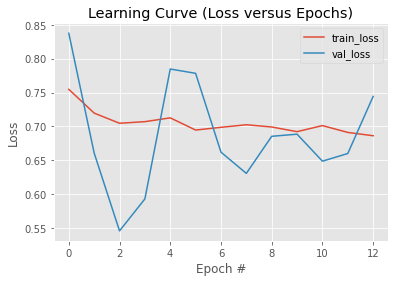

In [20]:
## plot figures

# Todo

plot_loss_history(history)

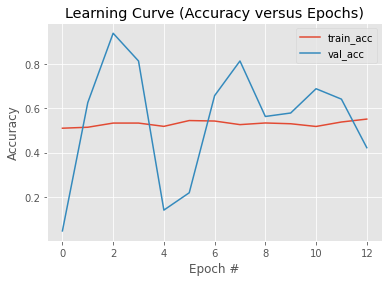

In [21]:
plot_acc_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [22]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

In [23]:
print(precision.shape, recall.shape, thresholds.shape)

print('\nThresholds:\n{}\n'.format(thresholds))

(29,) (29,) (28,)

Thresholds:
[0.42315233 0.42383614 0.4266921  0.42996725 0.4302841  0.43349767
 0.43943846 0.4420411  0.44686067 0.45103937 0.45172027 0.4557946
 0.4605808  0.4680069  0.46937016 0.4707858  0.4722558  0.47599304
 0.47853798 0.4817464  0.48332277 0.49086443 0.49426073 0.4951183
 0.49877462 0.4992923  0.49981767 0.52137434]



In [24]:
def compute_accuracy(threshold):
    t = (pred_Y[:, 0] > threshold)
    compare_t = (t == valY)
    return len(compare_t[compare_t]) / pred_Y.shape[0]

In [25]:
# Look at the threshold where precision is 0.8
print('Precisions:\n{}\n'.format(precision))
precision_value = 0.8
idx = np.nanargmin(np.abs(precision[:-1] - precision_value))
threshold1 = thresholds[idx]
print('Index is: {}'.format(idx))
print('Precision is: {:.4f} (closer to {})'.format(precision[idx], precision_value))
print('Recall is: {:.4f}'.format(recall[idx]))
print('Threshold is: {:.4f}'.format(threshold1))
print('F1 Score is: {:.4f}'.format(calc_f1(precision[idx],recall[idx])))
print('Accuracy is: {:.4f}'.format(compute_accuracy(threshold1)))

Precisions:
[0.10714286 0.07407407 0.07692308 0.08       0.08333333 0.08695652
 0.09090909 0.0952381  0.1        0.10526316 0.11111111 0.11764706
 0.125      0.13333333 0.14285714 0.15384615 0.16666667 0.18181818
 0.2        0.22222222 0.25       0.28571429 0.16666667 0.2
 0.25       0.         0.         0.         1.        ]

Index is: 21
Precision is: 0.2857 (closer to 0.8)
Recall is: 0.6667
Threshold is: 0.4909
F1 Score is: 0.4000
Accuracy is: 0.8906


In [26]:
# Look at the threshold where recall is 0.8
print('Recalls:\n{}\n'.format(recall))
recall_value = 0.8
idx = np.nanargmin(np.abs(recall[:-1] - recall_value))
threshold2 = thresholds[idx]
print('Index is: {}'.format(idx))
print('Precision is: {:.4f}'.format(precision[idx]))
print('Recall is: {:.4f} (closer to {})'.format(recall[idx], recall_value))
print('Threshold is: {:.4f}'.format(threshold2))
print('F1 Score is: {:.4f}'.format(calc_f1(precision[idx],recall[idx])))
print('Accuracy is: {:.4f}'.format(compute_accuracy(threshold2)))

Recalls:
[1.         0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667 0.33333333 0.33333333
 0.33333333 0.         0.         0.         0.        ]

Index is: 1
Precision is: 0.0741
Recall is: 0.6667 (closer to 0.8)
Threshold is: 0.4238
F1 Score is: 0.1333
Accuracy is: 0.6094


In [27]:
f1 = np.array([calc_f1(prec, rec) for prec, rec in zip(precision, recall)])
print('F1-scores:\n{}\n'.format(f1))

max_index = np.nanargmax(f1)
YOUR_THRESHOLD = thresholds[max_index]
max_f1 = f1[max_index]
print('Index is: {}'.format(max_index))
print('Optimal threshold: {:.4f}'.format(YOUR_THRESHOLD))
print('Maximum F1-score: {:.4f}'.format(max_f1))
print('Accuracy: {:.4f}'.format(compute_accuracy(YOUR_THRESHOLD)))

F1-scores:
[0.19354839 0.13333333 0.13793103 0.14285714 0.14814815 0.15384615
 0.16       0.16666667 0.17391304 0.18181818 0.19047619 0.2
 0.21052632 0.22222222 0.23529412 0.25       0.26666667 0.28571429
 0.30769231 0.33333333 0.36363636 0.4        0.22222222 0.25
 0.28571429        nan        nan        nan 0.        ]

Index is: 21
Optimal threshold: 0.4909
Maximum F1-score: 0.4000
Accuracy: 0.8906


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


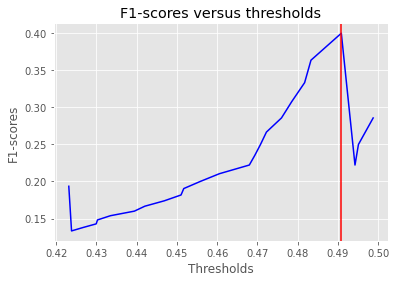

In [28]:
def plot_f1_score_versus_threshold():
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(thresholds, f1[:-1], color = 'b')
    plt.axvline(x = YOUR_THRESHOLD, color = 'r')
    plt.title("F1-scores versus thresholds")
    plt.xlabel("Thresholds")
    plt.ylabel("F1-scores")
    #plt.legend(loc="upper right")
    
plot_f1_score_versus_threshold()

In [29]:
accuracies = np.array([compute_accuracy(t) for t in thresholds])
max_acc_index = np.nanargmax(accuracies)
print('Maximum accuracy at threshold {:.4f}: {:.4f}'.format(thresholds[max_acc_index], accuracies[max_acc_index]))

Maximum accuracy at threshold 0.5214: 0.9531


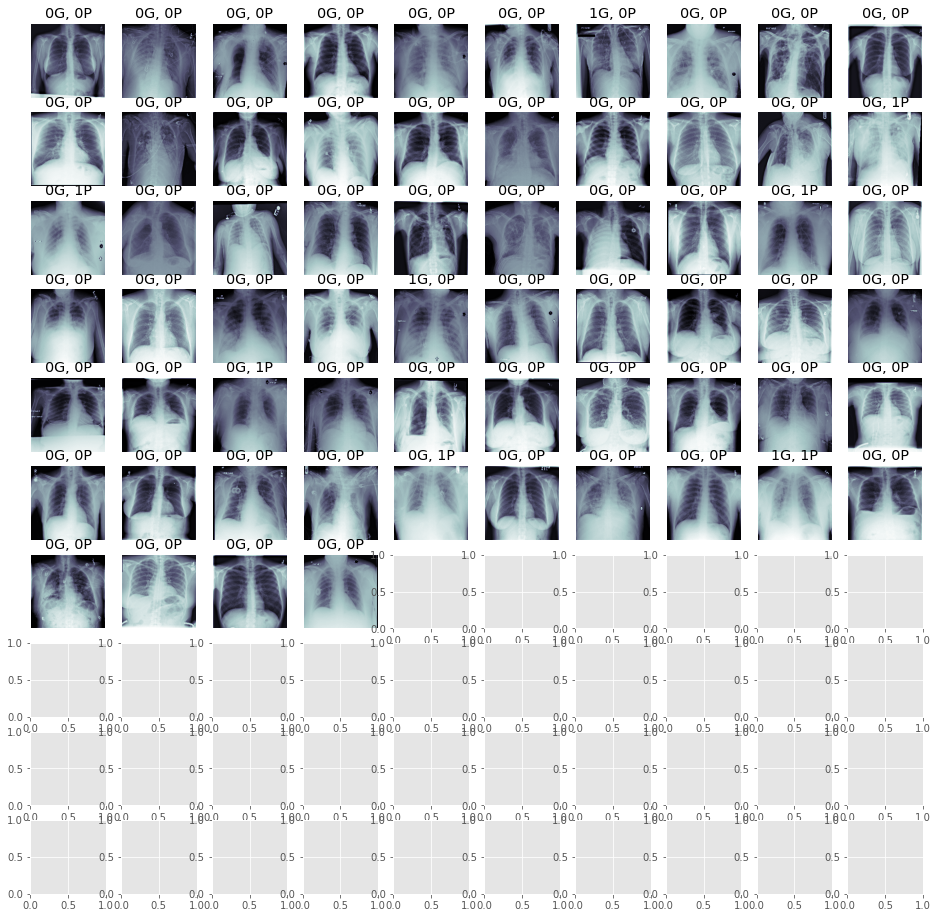

In [30]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1G, 1P')
        else:
            c_ax.set_title('1G, 0P')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0G, 1P')
        else:
            c_ax.set_title('0G, 0P')
    c_ax.axis('off')
    i=i+1

In [31]:
## Just save model architecture to a .json:

model_file = "model.json"
model_json = model.to_json()
with open(model_file, "w") as json_file:
    json_file.write(model_json)